In [ ]:
!pip install tensorflow==2.12.0
import pandas as pd
import tensorflow as tf
import numpy as np
from PIL import Image
from itertools import chain

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/
df = pd.read_csv("data_3.csv")

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
#konwersja
data = df.to_numpy()

# wszystkie dane z lidaru są numeryczne, więc konwertujemy do numpy
# obiekty w "nieskończości" są zapisywane jako 12 z kawałkiem, ale zostaną przycięte podczas tworzenia obrazka poniżej

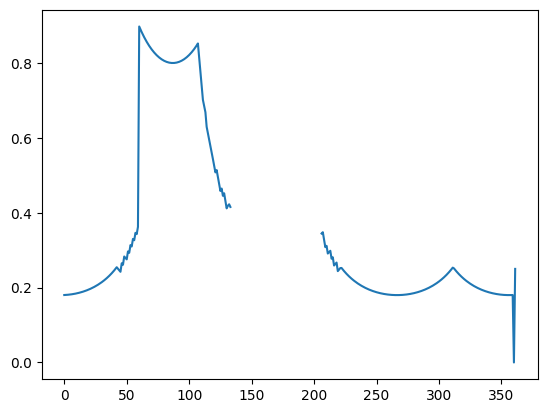

In [ ]:
# podejrzenie dancych na wykresie
data.shape[1]
for i in range(1):
  plt.plot(data[i])

plt.show()

In [ ]:
# liczba zarejestrowanych chwil czasowych - liczba wierszy data
length = data.shape[0]
length

# tworzenie danych wejściowych w postaci numpy 3d array. Dane są konwertowane na widok labiryntu w rzucie (w małym otoczeniu)
k = 24
dim = 48

# 3d array wypełniony na start zerami, liczba wierszy to liczba chwil czasowych, pozostałe dwa wymiary to macierz kwadratowa
matrix = np.zeros([length,dim,dim])

# ile stopni ma nie widzieć z tyłu
cut_angle = 90

# przechodzimy przez wyszystkie chwile czasowe
for el in range(length):
  # od kąta 0 do 134 (wycinamy 135-224 bo nie ma sensu uwzględniać tego co jest z tyłu)
  for i in chain(range(180-cut_angle//2), range(180+cut_angle//2,360)):
    # jeżeli odległość jest mniejsza od 1 - interesuje nas stosunkowe bliskie sąsiedztwo, dane z 3 ścian dalej, które akurat się załapały tylko przeszadzają. Trochę trzeba jak z koniem z klapkami na oczach
    if data[el,i] < 1:
      angle = np.radians(i) # konwersja do radianów bo taki argument przyjmuje trygonometria w numpy
      r = data[el,i] # promień to odłegość do przeszkody
      x = int(r * np.sin(angle) * k + dim //2) # współrzędna x to liczba naturalna int. sin razy promień razy współczynnik, żeby obrazek nie był za mały + współrzędne środka
      y = int(r * np.cos(angle) * k + dim //2)

      if 0 <= x < dim and 0 <= y < dim: # upewnienie się, że x i y mieszczą się w obrazku
              matrix[el,y,x] = 1


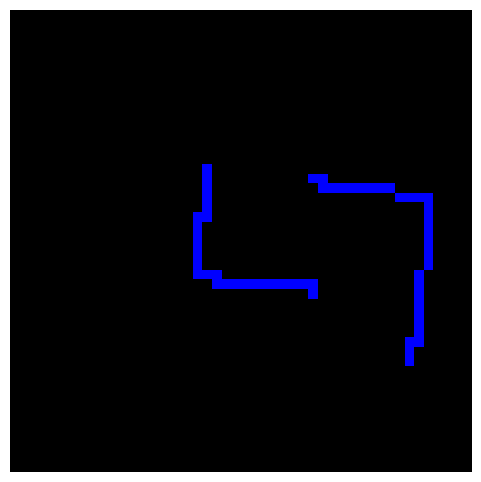

In [ ]:
# podgląd obrazka dla konkretnej chwili czasowej el
el = 10
image = np.zeros([dim, dim,3], dtype=np.uint8)

for i in chain(range(180-cut_angle//2), range(180+cut_angle//2,360)):
    if data[el,i] < 1:
      angle = np.radians(i)
      r = data[el,i]
      x = int(r * np.sin(angle) * k + dim //2)
      y = int(r * np.cos(angle) * k + dim //2)

      if 0 <= x < dim and 0 <= y < dim:
        image[y,x] = [0,0,255]


img = Image.fromarray(image, 'RGB')
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#dzielenie za zbiór uczący i testowy
# wydobycie 2 ostatnich kolumn czyli cmd_vel x i obrót, które posłużą jako wyjście z modelu
y = data[:,360:362]

# obliczenie ile chwil czasowych to 0.8 całości. Dzielimy w taki sposób, że 80% idzie do uczącego a 20% do testowego (walidacyjnego)
part = int(length*0.8)

y_train, y_test = np.split(y, [part])
x_train, x_test = np.split(matrix, [part], axis=0)

print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

x train shape: (18394, 48, 48)
x test shape: (4599, 48, 48)
y train shape: (18394, 2)
y test shape: (4599, 2)


In [ ]:
# budowa konwolucyjnej sieci neuronowej

input_shape = (dim, dim,1)


input_layer = layers.Input(shape=input_shape, name="input_layer")
# warstwa konwolucyjna z 32 maskami o wymiarach 5x5, stride domyślny 1, funckja aktywacyjna relu, wskazanie warstwy poprzedzającej
convo_1 = layers.Conv2D(32, (5, 5), activation='relu')(input_layer)
# warstwa max pooling do zmniejszenia wymiarów macierzy i wydobycia najcenniejszych informacji, 2x2 zamieniane na 1, stride domyślny 2
pool_1 = layers.MaxPooling2D(pool_size=(2,2))(convo_1)

# warstwa konwolucyjna z 64 maskami o wymiarach 3x3, stride domyślny 1, funckja aktywacyjna relu, wskazanie warstwy poprzedzającej
convo_2 = layers.Conv2D(64, (3, 3), activation='relu')(pool_1)
pool_2 =layers.MaxPooling2D(pool_size=(2,2))(convo_2)
# spłaszczenie neuronów ciągu
flat = layers.Flatten()(pool_2)

# tak na prawdę piersza warstwa o 128 neuronach z funkcją aktywacyjną relu
dense = layers.Dense(128, activation= 'relu')(flat)
# wyrzucenie 25% neuronów
drop = layers.Dropout(0.25)(dense)
# warstwa końcowa z 2 neuronami w postaci cmd_vel do przodu i obrót
y_output = layers.Dense(2, activation= 'linear', name="y_output")(drop)

model = tf.keras.Model(inputs = input_layer, outputs = y_output)


# wybranie sposobu aktualizacji kolejnego gradientu jako adam (popularny i dobry), loss liczone jako mean square error a metrics jako mean absolute error
model.compile(optimizer='adam',
              loss='mse',  # Use appropriate loss function for your problem
              metrics=['mae']) # Use appropriate metrics

model.summary()
# start uczenia, 5 epok
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# zapisanie loss i accuracy do zmiennych
loss, accuracy = model.evaluate(x_test, y_test)



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6400)              0   

In [ ]:
# zapisanie gotowego modelu jako .keras
model.save("./my_model_0deg.keras")

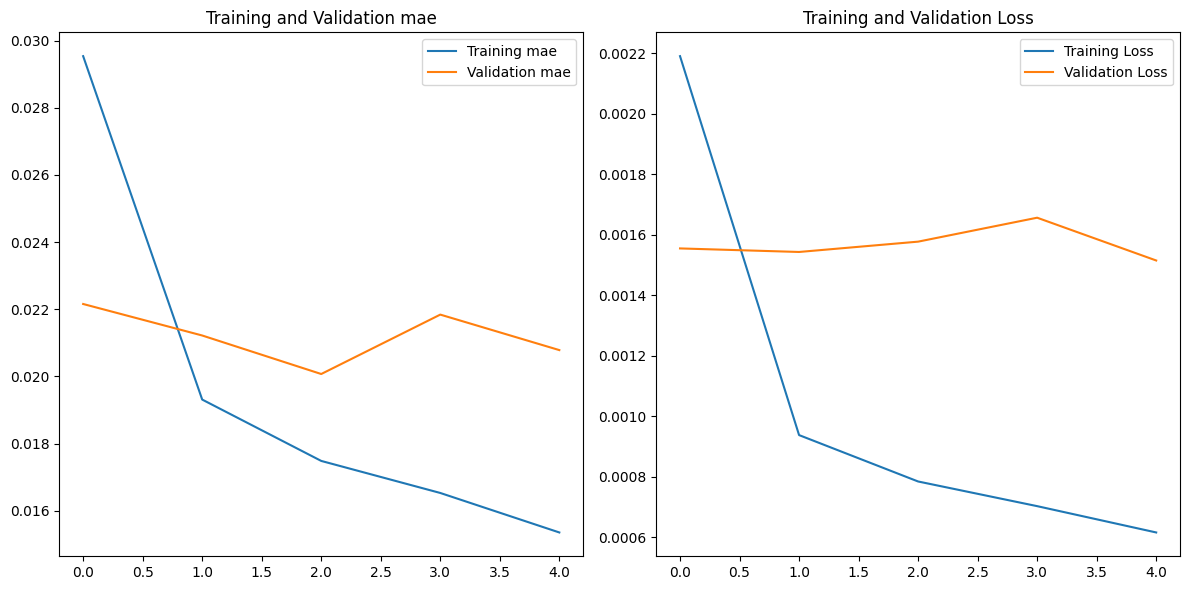

In [ ]:
# zapisanie mae i loss do zmiennych
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

# wykres mae
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, mae, label='Training mae')
plt.plot(epochs, val_mae, label='Validation mae')
plt.title('Training and Validation mae')
plt.legend()

# wykres loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()